any function that's passed to a multiprocessing function must be defined globally, even the callback function

size decompressed = 3.7 * compressed

# Config

In [1]:
# Reload all src modules every time before executing the Python code typed
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import json
import cProfile
import pandas as pd
import geopandas as geopd
import numpy as np
import multiprocessing as mp
try:
    import cld3
except ModuleNotFoundError:
    pass
import pycld2
from shapely.geometry import MultiPolygon
from shapely.geometry import Polygon
from shapely.geometry import Point
import matplotlib.cm as csshm
import matplotlib.pyplot as plt
import descartes
import datetime
import src.utils.geometry as geo
import src.utils.places_to_cells as places_to_cells
import src.utils.join_and_count as join_and_count
import src.utils.make_config as make_config
import src.data.shp_extract as shp_extract
import src.data.text_process as text_process
import src.data.access as data_access
import src.data.user_filters as ufilters
import src.data.user_agg as uagg
import src.data.metrics as metrics
import src.data.process as data_process
import src.data.cells_results as cells_results
import src.visualization.grid_viz as grid_viz
import src.visualization.helpers as helpers_viz
from dotenv import load_dotenv
load_dotenv()

pd.reset_option("display.max_rows")

In [3]:
data_dir_path = os.environ['DATA_DIR']
tweets_files_format = 'tweets_{}_{}_{}.json.gz'
places_files_format = 'places_{}_{}_{}.json.gz'
ssh_domain = os.environ['IFISC_DOMAIN']
ssh_username = os.environ['IFISC_USERNAME']
fig_dir = os.path.join('..', 'reports', 'figures')
project_data_dir = os.path.join('..', 'data')
external_data_dir = os.path.join(project_data_dir, 'external')
interim_data_dir = os.path.join(project_data_dir, 'interim')
processed_data_dir = os.path.join(project_data_dir, 'processed')
cell_data_path_format = os.path.join(
    processed_data_dir, '{0}', '{0}_cc={1}_r={2}_cell_size={3}m.{4}')

latlon_proj = 'epsg:4326'
LANGS_DICT = dict([(lang[1],lang[0].lower().capitalize())
                   for lang in pycld2.LANGUAGES])

country_codes = ('BE', 'BO', 'CA', 'CH', 'EE', 'ES', 'FR', 'HK', 'ID', 'LT', 
                 'LV', 'MY', 'PE', 'RO', 'SG', 'TN', 'UA')
with open(os.path.join(external_data_dir, 'countries.json')) as f:
    countries_study_data = json.load(f)
with open(os.path.join(external_data_dir, 'langs_agg.json')) as f:
    langs_agg_dict = json.load(f)

# Country-specific parameters
cc = 'BE'
region = None #'New York City'
# region = 'Quebec'
# region = 'Cataluña'
area_dict = make_config.area_dict(countries_study_data, cc, region=region)
country_name = area_dict['readable']    
cc_fig_dir = os.path.join(fig_dir, cc)
if not os.path.exists(cc_fig_dir):
    os.makedirs(os.path.join(cc_fig_dir, 'count'))
    os.makedirs(os.path.join(cc_fig_dir, 'prop'))
xy_proj = area_dict['xy_proj']
cc_timezone = area_dict['timezone']
plot_langs_list = area_dict['local_langs']
min_poly_area = area_dict.get('min_poly_area')
max_place_area = area_dict.get('max_place_area') or 1e9
valid_uids_path = os.path.join(interim_data_dir, f'valid_uids_{cc}_{country_name}.csv')

# Getting the data

## Places, area and grid

In [4]:
shapefile_dict = make_config.shapefile_dict(area_dict, cc, region=region)
    
shapefile_path = os.path.join(
    external_data_dir, shapefile_dict['name'], shapefile_dict['name'])
shape_df = geopd.read_file(shapefile_path)
shape_df = geo.extract_shape(
    shape_df, shapefile_dict, xy_proj=xy_proj, min_area=min_poly_area)
shape_df

,CNTR_ID,CNTR_NAME,NAME_ENGL,ISO3_CODE,FID,geometry
16,BE,Belgien-Belgique-België,Belgium,BEL,BE,"POLYGON ((766579.841 661733.616, 767926.719 66..."


Places can be a point too -> treat them like tweets with coords in this case

In [7]:
places_files_paths = [
    os.path.join(data_dir_path, places_files_format.format(2015, 2018, cc)),
    os.path.join(data_dir_path, places_files_format.format(2019, 2019, cc))]
all_raw_places_df = []
for file in places_files_paths:
    raw_places_df = data_access.return_json(file,
        ssh_domain=ssh_domain, ssh_username=ssh_username, compression='gzip')
    all_raw_places_df.append(
        raw_places_df[['id', 'bounding_box', 'name', 'place_type']])
# We drop the duplicate places (based on their ID)
places_df = pd.concat(all_raw_places_df).drop_duplicates(subset='id')
places_geodf, places_in_xy = geo.make_places_geodf(places_df, shape_df,
                                                   xy_proj=xy_proj)
places_geodf.head()

,name,place_type,min_lon,min_lat,max_lon,max_lat,geometry,area
place_id,,,,,,,,
fdcd591ad1a5ebdf,Essen,city,4.379667,51.415275,4.547779,51.482376,"POLYGON ((650750.836 733954.360, 650748.780 74...",6.342688e+07
2a8a74486cd0d519,Amberes,city,4.218084,51.143464,4.498296,51.377649,"POLYGON ((639451.508 703722.799, 639501.030 72...",4.902176e+08
67687709552688fe,Ghent,city,3.579764,50.979531,3.849360,51.187961,"POLYGON ((594591.009 685763.633, 594834.412 70...",4.380232e+08
6d6198a460e4073a,Mechelen,city,4.370328,50.991188,4.548736,51.078574,"POLYGON ((650108.193 686773.122, 650106.738 69...",1.216540e+08
2c59b4de6ca18752,Les Bons Villers,city,4.372659,50.475391,4.513065,50.564687,"POLYGON ((650282.188 629397.493, 650280.390 63...",9.889719e+07


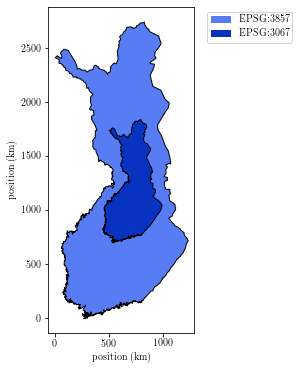

In [336]:
from matplotlib.patches import Patch
    # plt.rc('text', usetex=True)
    # plt.rc('font', family='serif')
shape_df = geopd.read_file(shapefile_path)
shape_df = geo.extract_shape(
    shape_df, shapefile_dict, xy_proj=xy_proj, min_area=min_poly_area)
mercator_proj = 'epsg:3857'
fig, ax = plt.subplots(1, figsize=(10, 6))

xlabel = 'position (km)'
ylabel = 'position (km)'
shape_df_mercator = shape_df.to_crs(mercator_proj)
area_df_bounds = shape_df_mercator.geometry.iloc[0].bounds
# We translate the whole geometries so that the origin (x,y) = (0,0) is
# located at the bottom left corner of the shape's bounding box.
x_off = -area_df_bounds[0]
y_off = -area_df_bounds[1]
shape_df_mercator.geometry = shape_df_mercator.translate(xoff=x_off, yoff=y_off)

shape_df_bounds = shape_df.geometry.iloc[0].bounds
# We translate the whole geometries so that the origin (x,y) = (0,0) is
# located at the bottom left corner of the shape's bounding box.
x_off = -(shape_df_bounds[2] + shape_df_bounds[0]) / 2 + (area_df_bounds[2] - area_df_bounds[0]) / 2 + 100e3
y_off = -(shape_df_bounds[3] + shape_df_bounds[1]) / 2 + (area_df_bounds[3] - area_df_bounds[1]) / 2 - 100e3
shape_df.geometry = shape_df.translate(xoff=x_off, yoff=y_off)
# The order here is important, the area's boundaries will be drawn on top
# of the choropleth, and the cells with null values will be in null_color
shape_df_mercator.plot(ax=ax, color='#587cf3', edgecolor='black')
shape_df.plot(ax=ax, color='#0833c1', edgecolor='black')

xticks_km = ax.get_xticks() / 1000
ax.set_xticklabels([f'{t:.0f}' for t in xticks_km])
yticks_km = ax.get_yticks() / 1000
ax.set_yticklabels([f'{t:.0f}' for t in yticks_km])

plt.xlabel(xlabel)
plt.ylabel(ylabel)
handles = [Patch(facecolor='#587cf3', label='EPSG:3857'), 
 Patch(facecolor='#0833c1', label='EPSG:3067')]
ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc=2)
plt.savefig('mercator_finland.pdf', bbox_inches='tight')
plt.show()
plt.close()

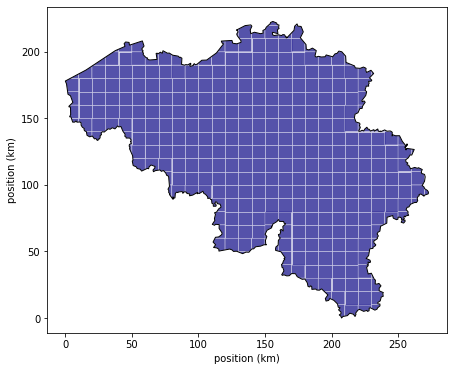

In [8]:
cell_size = 10000
cells_df, cells_in_area_df, Nx, Ny = geo.create_grid(
    shape_df, cell_size, xy_proj=xy_proj, intersect=True)
grid_test_df = cells_in_area_df.copy()
grid_test_df['metric'] = 1
# save_path = os.path.join(cc_fig_dir, f'grid_cc={cc}_cell_size={cell_size}m.pdf')
save_path = None
plot_kwargs = dict(alpha=0.7, edgecolor='w', linewidths=0.5, cmap='plasma')
ax = grid_viz.plot_grid(grid_test_df, shape_df, metric_col='metric', show=True, 
                        save_path=save_path, xy_proj=xy_proj, **plot_kwargs)

In [85]:
cells_df, cells_in_area_df, Nx, Ny = geo.create_grid(
    shape_df, cell_size, xy_proj=xy_proj, intersect=True, places_geodf=places_geodf)

In [86]:
import mplleaflet
cells_in_shape_df.to_crs(latlon_proj).plot(edgecolor='w', figsize=(6,10))
mplleaflet.display()

/home/thomaslouf/Documents/code/multiling-twitter/.venv/lib/python3.6/site-packages/IPython/core/display.py:701: UserWarning:

Consider using IPython.display.IFrame instead



In [83]:
tweets_files_paths = [
    os.path.join(data_dir_path, tweets_files_format.format(2015, 2019, cc))]
#     os.path.join(data_dir_path, tweets_files_format.format(2019, 2019, cc))]

tweets_access_res = None

## Reading the data

In [49]:
def profile_pre_process(tweets_file_path, chunk_start, chunk_size):
    cProfile.runctx(
        '''data_access.read_data(
        tweets_file_path, chunk_start, chunk_size, dfs_to_join=[places_geodf])''', 
        globals(), locals())

tweets_access_res = []
def collect_tweets_access_res(res):
    global tweets_access_res
    if res.shape[0] > 0:
        tweets_access_res.append(res)
    
pool = mp.Pool(8)
for file_path in tweets_files_paths:
    for chunk_start, chunk_size in data_access.chunkify(
            file_path, size=1e9, ssh_domain=ssh_domain, 
            ssh_username=ssh_username):
        args = (file_path, chunk_start, chunk_size)
        kwargs = {'cols': ['text', 'id', 'lang', 'place_id', 'coordinates', 
                           'uid', 'created_at', 'source'],
                  'dfs_to_join': [places_geodf]}
        pool.apply_async(
            data_access.read_data, args, kwargs, callback=collect_tweets_access_res)
pool.close()
pool.join()

tweets_access_res = data_process.post_multi(tweets_access_res)

1000MB read, 846686 tweets unpacked.
0 tweets remaining after filters.


Process ForkPoolWorker-147:
Process ForkPoolWorker-154:
Traceback (most recent call last):


KeyboardInterrupt: 

  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-153:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/thomaslouf/Documents/code/multiling-twitter/src/data/access.py", line 25, in read_data
    ssh_username=ssh_username)
Traceback (most recent call last):
  File "/home/thomaslouf/Documents/code/multiling-twitter/src/data/access.py", line 124, in read_json_wrapper
    f.seek(chunk_start)
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/gzip.py", line 368, in seek
    return self._buffer.seek(offset, whence)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/py

1000MB read, 852716 tweets unpacked.
0 tweets remaining after filters.


Process ForkPoolWorker-149:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/thomaslouf/Documents/code/multiling-twitter/src/data/access.py", line 25, in read_data
    ssh_username=ssh_username)
  File "/home/thomaslouf/Documents/code/multiling-twitter/src/data/access.py", line 126, in read_json_wrapper
    raw_tweets_df = pd.read_json(lines, lines=True)
  File "/home/thomaslouf/Documents/code/multiling-twitter/.venv/lib/python3.6/site-packages/pandas/io/json/_json.py", line 592, in read_json
    result = json_reader.read()
  File "/home/thomaslouf/Documents/code/multiling-twitter/.venv/lib/python3.6/site-packages/pandas/io/json/_json.py", line 715, in read
    obj

In [ ]:
tweeted_months = None
tweets_pb_months = None
first_day = datetime.datetime(year=2015, month=1, day=1)
for res in tweets_access_res:
    tweets_df = res.copy()
    tweets_df = tweets_df.loc[tweets_df['created_at'] > first_day]
    tweets_df['month'] = tweets_df['created_at'].dt.to_period('M')
    has_gps = tweets_df['coordinates'].notnull()
    geometry = tweets_df.loc[has_gps, 'coordinates'].apply(
        lambda x: Point(x['coordinates']))
    tweets_coords = geopd.GeoSeries(geometry, crs=latlon_proj, 
                                    index=tweets_df.loc[has_gps].index)
    tweets_df = tweets_df.join(places_geodf, on='place_id', how='left')
    coords_in_place = tweets_coords.within(
        geopd.GeoSeries(tweets_df.loc[has_gps, 'geometry']))
    
    tweeted_months = join_and_count.increment_counts(
        tweeted_months, tweets_df, ['month'])
    tweets_pb_months = join_and_count.increment_counts(tweets_pb_months, 
        tweets_df.loc[has_gps].loc[~coords_in_place], ['month'])

In [ ]:
months_counts = tweeted_months.join(tweets_pb_months, rsuffix='_pb', how='left')
months_counts['prop'] = months_counts['count_pb'] / months_counts['count']
ax = months_counts['prop'].plot.bar()
ticks = np.arange(0,60,5)
tick_labels = ax.get_xticklabels()
_ = ax.set_xticks(ticks)
_ = ax.set_xticklabels([tick_labels[i] for i in ticks])
_ = ax.set_ylabel('proportion')
_ = ax.set_title('Proportion of tweets with coords outside of place')

## Filtering out users

Filters: user-based imply a loop over all the raw_tweets_df, and must be applied before getting tweets_lang_df and even tweets_loc_df, because these don't interest us at all.

This filter requires us to loop over all files and aggregate the results to get the valid UIDs out

In [65]:
if tweets_access_res is None:
    def get_df_fun(arg0):
        return data_access.read_json_wrapper(*arg0)
else:
    def get_df_fun(arg0):
        return arg0

def chunk_users_months(df_access, get_df_fun, places_geodf,
                       cols=None, ref_year=2015):
    raw_tweets_df = get_df_fun(df_access)
    raw_tweets_df = data_access.filter_df(
        raw_tweets_df, cols=cols, dfs_to_join=[places_geodf])
    months_counts = uagg.users_months(raw_tweets_df, ref_year=ref_year)
    return months_counts

users_months_res = []
def collect_users_months_res(res):
    global users_months_res
    if res.shape[0] > 0:
        users_months_res.append(res)

pool = mp.Pool(8)
for df_access in data_access.yield_tweets_access(
        tweets_files_paths, tweets_res=tweets_access_res):
    args = (df_access, get_df_fun, places_geodf)
    kwargs = {'cols': ['id', 'uid', 'created_at']}
    pool.apply_async(
        chunk_users_months, args, kwargs, 
        callback=collect_users_months_res, error_callback=print)
pool.close()
pool.join()

tweeted_months_users = join_and_count.init_counts(['uid', 'month'])
for res in users_months_res:
    tweeted_months_users = join_and_count.increment_join(tweeted_months_users, 
                                                         res)
        
tweeted_months_users = tweeted_months_users['count']
total_nr_users = len(tweeted_months_users.index.levels[0])
print(f'In total, there are {total_nr_users} distinct users in the whole dataset.')

1000MB read, 846686 tweets unpacked.
846158 tweets remaining after filters.
There are 53374 distinct users in this chunk.
1000MB read, 852716 tweets unpacked.
1000MB read, 844912 tweets unpacked.
851955 tweets remaining after filters.
There are 58630 distinct users in this chunk.
844554 tweets remaining after filters.
1000MB read, 841957 tweets unpacked.
There are 50863 distinct users in this chunk.
841447 tweets remaining after filters.
There are 47048 distinct users in this chunk.
1000MB read, 839053 tweets unpacked.
838673 tweets remaining after filters.
There are 54232 distinct users in this chunk.
1000MB read, 846221 tweets unpacked.
115.6MB read, 94907 tweets unpacked.
94823 tweets remaining after filters.
There are 10020 distinct users in this chunk.
845824 tweets remaining after filters.
1000MB read, 810121 tweets unpacked.
There are 52818 distinct users in this chunk.
1000MB read, 831641 tweets unpacked.
809591 tweets remaining after filters.
831108 tweets remaining after filt

In [66]:
local_uids = ufilters.consec_months(tweeted_months_users)
bot_uids = ufilters.bot_activity(tweeted_months_users)
# We have local_uids: index of uids with a column full of True, and bot_uids:
# index of uids with a column full of False. When we multiply them, the uids
# in local_uids which are not in bot_uids are assigned NaN, and the ones which 
# are in bot_uids are assigned False. When we convert to the boolean type,
# the NaNs turn to True.
valid_uids = (local_uids * bot_uids).astype('bool').rename('valid')
valid_uids = valid_uids.loc[valid_uids]
print(f'This leaves us with {len(valid_uids)} valid users in the whole dataset.')

There are 66972 users with at least 3 months of activity in the dataset.
There are 36284 users considered local in the dataset, as they have been active for 3 consecutive months in this area at least once.
0 users have been found to be bots because of their excessive activity, tweeting more than 3 times per minute.
This leaves us with 36284 valid users in the whole dataset.


Then we have to loop over all files once again to apply the speed filter, which is expensive, thus done last (we thus benefit from having some users already filtered out, so smaller tweets dataframes)

In [ ]:
if tweets_access_res is None:
    def get_df_fun(arg0):
        return data_access.read_json_wrapper(*arg0)
else:
    def get_df_fun(arg0):
        return arg0

def speed_filter(df_access, get_df_fun, valid_uids, places_in_xy, max_distance,
                 cols=None):
    tweets_df = get_df_fun(df_access)
    tweets_df = data_access.filter_df(
        tweets_df, cols=cols, dfs_to_join=[places_in_xy, valid_uids])
    too_fast_uids = ufilters.too_fast(tweets_df, places_in_xy, max_distance)
    return too_fast_uids

area_bounds = shape_df.to_crs(xy_proj).geometry.iloc[0].bounds
# Get an upper limit of the distance that can be travelled inside the area
max_distance = np.sqrt((area_bounds[0]-area_bounds[2])**2 
                       + (area_bounds[1]-area_bounds[3])**2)
cols = ['uid', 'created_at', 'place_id', 'coordinates']

too_fast_uids_list = []
def collect_too_fast_uids_list(res):
    global too_fast_uids_list
    if res.shape[0] > 0:
        too_fast_uids_list.append(res)
        
pool = mp.Pool(8)
for df_access in data_access.yield_tweets_access(
        tweets_files_paths, tweets_res=tweets_access_res):
    args = (df_access, get_df_fun,
            valid_uids, places_geodf, max_distance)
    kwargs = {'cols': cols}
    pool.apply_async(
        speed_filter, args, kwargs, callback=collect_too_fast_uids_list,
        error_callback=print)
pool.close()
pool.join()

too_fast_uids_series = pd.Series([])
too_fast_uids_series.index.name = 'uid'
for too_fast_uids in too_fast_uids_list:
    too_fast_uids_series = (too_fast_uids_series * too_fast_uids).fillna(False)
print(f'In total, there are {len(too_fast_uids_series)} too fast users left to '
      'filter out in the whole dataset.')

valid_uids = (valid_uids * too_fast_uids_series).astype('bool').rename('valid')
valid_uids = valid_uids.loc[valid_uids]
print(f'This leaves us with {len(valid_uids)} valid users in the whole dataset.')
valid_uids.to_csv(valid_uids_path, header=True)

## Processing

We don't filter out tweets with a useless place (one too large) here, because these tweets can still be useful for language detection. So this filter is only applied later on. Similarly, we keep tweets with insufficient text to make a reliable language detection, because they can still be useful for residence attribution.

In [9]:
valid_uids = pd.read_csv(valid_uids_path, index_col='uid', header=0)

if tweets_access_res is None:
    def get_df_fun(arg0):
        return data_access.read_json_wrapper(*arg0)
else:
    def get_df_fun(arg0):
        return arg0
    
tweets_process_res = []
def collect_tweets_process_res(res):
    global tweets_process_res
    if res.shape[0] > 0:
        tweets_process_res.append(res)

def access_and_process(df_access, get_df_fun, valid_uids, places_geodf, 
                       langs_agg_dict, text_col='text', min_nr_words=4, 
                       cld='pycld2', latlon_proj='epsg:4326'):
    tweets_loc_df = get_df_fun(df_access)
    cols = ['text', 'id', 'lang', 'place_id', 'coordinates', 'uid',
            'created_at', 'source']
    tweets_loc_df = data_access.filter_df(
        tweets_loc_df, cols=cols, dfs_to_join=[places_geodf, valid_uids])
    tweets_lang_df = data_process.process(
        tweets_loc_df, places_geodf, langs_agg_dict,
        min_nr_words=min_nr_words, cld=cld)
    return tweets_lang_df

pool = mp.Pool(8)
for df_access in data_access.yield_tweets_access(
        tweets_files_paths, tweets_res=tweets_access_res):
    args = (df_access, get_df_fun,
            valid_uids, places_geodf, langs_agg_dict)
    kwargs = {'min_nr_words': 4, 'cld': 'pycld2'}
    pool.apply_async(
        access_and_process, args, kwargs, callback=collect_tweets_process_res,
        error_callback=print)
pool.close()
pool.join()
    
tweets_process_res = data_process.post_multi(tweets_process_res)

/home/thomaslouf/Documents/code/multiling-twitter/.venv/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike



lol
starting lang detect
Can only use .str accessor with string values!


# Study at the tweet level

## Make tweet counts data

In [39]:
tweet_level_label = 'tweets in {}'
plot_langs_dict = make_config.langs_dict(area_dict, tweet_level_label)

Why sjoin so slow? It tests on every cell, even though it's exclusive: if one cell matches no other will. Solution: loop over cells, ordered by the counts obtained from places, and stop at first match, will greatly reduce the number of 'within' operations -> update: doesn't seem possible, deleting from spatial index is extremely slow

In [40]:
def get_langs_counts(tweets_lang_df, max_place_area, cells_in_area_df):
    tweets_df = tweets_lang_df.copy()
    relevant_area_mask = tweets_df['area'] < max_place_area
    tweets_df = tweets_df.loc[relevant_area_mask]
    # The following mask accounts for both tweets with GPS coordinates and
    # tweets within places which are a point.
    has_gps = tweets_df['area'] == 0
    # Here the tweets with coordinates outside the grid are out, because of the
    # inner join
    tweets_cells_df = geopd.sjoin(tweets_df.loc[has_gps], cells_in_area_df,
        op='within', rsuffix='cell', how='inner')
    nr_out_tweets =  len(tweets_df.loc[has_gps]) - len(tweets_cells_df)
    print(f'{nr_out_tweets} tweets have been found outside of the grid and'
         ' filtered out as a result.')
    tweets_places_df = tweets_df.loc[~has_gps]
    return tweets_cells_df, tweets_places_df
    
with mp.Pool(8) as pool:
    map_parameters = [(res, max_place_area, cells_in_area_df) 
                      for res in tweets_process_res]
    print('entering the loop')
    tweets_pre_cell_res = (
        pool.starmap_async(get_langs_counts, map_parameters).get())

cells_langs_counts = None
places_langs_counts = None

for res in tweets_pre_cell_res:
    tweets_cells_df = res[0]
    tweets_places_df = res[1]
    groupby_cols = ['cld_lang', 'cell_id']
    cells_langs_counts = join_and_count.increment_counts(
        cells_langs_counts, tweets_cells_df, groupby_cols)
    groupby_cols = ['cld_lang', 'place_id']
    places_langs_counts = join_and_count.increment_counts(
        places_langs_counts, tweets_places_df, groupby_cols)

places_langs_counts = places_langs_counts['count']
places_counts = (places_langs_counts.groupby('place_id')
                                   .sum()
                                   .rename('total_count')
                                   .to_frame())
cells_langs_counts = cells_langs_counts['count']
cells_counts = (cells_langs_counts.groupby('cell_id')
                                  .sum()
                                  .rename('total_count')
                                  .to_frame())

entering the loop
109 tweets have been found outside of the grid and filtered out as a result.
123 tweets have been found outside of the grid and filtered out as a result.
119 tweets have been found outside of the grid and filtered out as a result.
149 tweets have been found outside of the grid and filtered out as a result.
120 tweets have been found outside of the grid and filtered out as a result.
129 tweets have been found outside of the grid and filtered out as a result.
180 tweets have been found outside of the grid and filtered out as a result.
127 tweets have been found outside of the grid and filtered out as a result.
148 tweets have been found outside of the grid and filtered out as a result.
103 tweets have been found outside of the grid and filtered out as a result.
100 tweets have been found outside of the grid and filtered out as a result.
111 tweets have been found outside of the grid and filtered out as a result.
96 tweets have been found outside of the grid and filtered

Places -> cells

In [41]:
# We count the number of users speaking a local language in each cell and place 
# of residence.
local_langs = [lang for lang in plot_langs_dict]
places_local_counts = places_langs_counts.reset_index(level='cld_lang')
local_langs_mask = places_local_counts['cld_lang'].isin(local_langs)
places_local_counts = (places_local_counts.loc[local_langs_mask]
                                          .groupby('place_id')['count']
                                          .sum()
                                          .rename('local_count'))
places_counts = places_counts.join(places_local_counts, how='left')

cells_local_counts = cells_langs_counts.reset_index(level='cld_lang')
local_langs_mask = cells_local_counts['cld_lang'].isin(local_langs)
cells_local_counts = (cells_local_counts.loc[local_langs_mask]
                                        .groupby('cell_id')['count']
                                        .sum()
                                        .rename('local_count'))
cells_counts = cells_counts.join(cells_local_counts, how='left')

cell_plot_df = places_to_cells.get_counts(
    places_counts, places_langs_counts, places_geodf,
    cells_in_area_df, plot_langs_dict)

# We add the counts from the tweets with coordinates
cell_plot_df = join_and_count.increment_join(
    cell_plot_df, cells_counts['total_count'], count_col='total_count')
cell_plot_df = join_and_count.increment_join(
    cell_plot_df, cells_counts['local_count'], count_col='local_count')
cell_plot_df = cell_plot_df.loc[cell_plot_df['total_count'] > 0]

for plot_lang, lang_dict in plot_langs_dict.items():
    lang_count_col = lang_dict['count_col']
    cells_lang_counts = cells_langs_counts.xs(plot_lang).rename(lang_count_col)
    cell_plot_df = join_and_count.increment_join(
        cell_plot_df, cells_lang_counts, count_col=lang_count_col)
    
    level_lang_label = tweet_level_label.format(lang_dict['readable'])
    sum_lang = cell_plot_df[lang_count_col].sum()
    print(f'There are {sum_lang:.0f} {level_lang_label}.')
    
cell_plot_df['cell_id'] = cell_plot_df.index
cell_data_path = cell_data_path_format.format('tweets', cc, cell_size)
cell_plot_df.to_file(cell_data_path, driver='GeoJSON')

There are 9010159 tweets in Spanish.
There are 5035352 tweets in Catalan.


## Plots

In [42]:
# cell_size = 20000
cell_data_path = cell_data_path_format.format('tweets', cc, cell_size)
cell_plot_df = geopd.read_file(cell_data_path)
cell_plot_df.index = cell_plot_df['cell_id']
cell_plot_df, plot_langs_dict = metrics.calc_by_cell(cell_plot_df, plot_langs_dict)

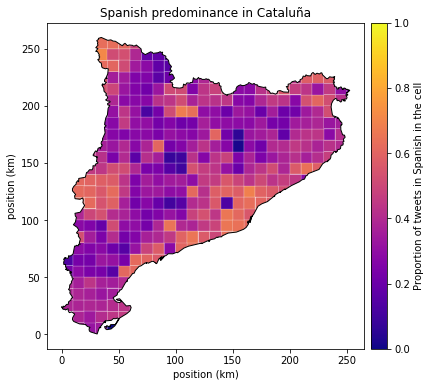

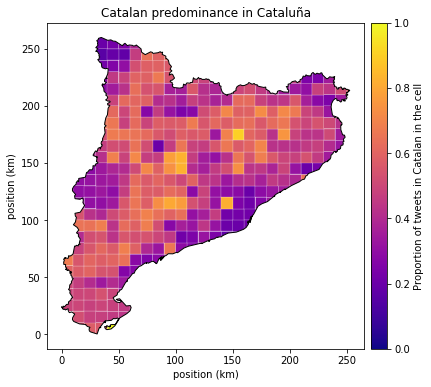

In [43]:
for plot_lang, plot_dict in plot_langs_dict.items():
    count_lang_col = plot_dict['count_col']
    readable_lang = plot_dict['readable']
    save_path = os.path.join(cc_fig_dir, 'count',
        f'tweet_counts_cc={cc}_lang={plot_lang}_cell_size={cell_size}m.pdf')
    plot_title = f'Distribution of {readable_lang} speakers in {country_name}'
    cbar_label = plot_dict['count_label']
    plot_kwargs = dict(edgecolor='w', linewidths=0.2, cmap='Purples')
    ax_count = grid_viz.plot_grid(
        cell_plot_df, shape_df, metric_col=count_lang_col, save_path=save_path, 
        show=False, log_scale=True, title=plot_title, cbar_label=cbar_label,
        xy_proj=xy_proj, **plot_kwargs)
    
    prop_lang_col = plot_dict['prop_col']
    save_path = os.path.join(cc_fig_dir, 'prop',
        f'tweets_prop_cc={cc}_lang={plot_lang}_cell_size={cell_size}m.pdf')
    plot_title = '{} predominance in {}'.format(readable_lang, country_name)
    cbar_label = plot_dict['prop_label']
    # Avoid sequential colormaps starting or ending with white, as white is  
    # reserved for an absence of data
    plot_kwargs = dict(edgecolor='w', linewidths=0.2, cmap='plasma')
    ax_prop = grid_viz.plot_grid(
        cell_plot_df, shape_df, metric_col=prop_lang_col, save_path=save_path, 
        title=plot_title, cbar_label=cbar_label, vmin=0, vmax=1, xy_proj=xy_proj, 
        **plot_kwargs)

In [44]:
save_path = os.path.join(cc_fig_dir, 
            f'tweets_prop_cc={cc}_cell_size={cell_size}m.html')
prop_dict = {'name': 'prop', 'readable': 'proportion', 'vmin': 0, 'vmax': 1}
fig = grid_viz.plot_interactive(
    cell_plot_df, shape_df, plot_langs_dict, prop_dict,
    save_path=save_path, plotly_renderer='iframe_connected', show=True)

# Study at the user level

Users who have tagged their tweets with gps coordinates seem to do it regularly, as the median of the proportion of tweets they geo tag is at more than 75% on the first chunk -> it's worth it to try and get their cell of residence

In [21]:
a = tweets_process_res[0].copy()
a['has_gps'] = a['area'] == 0
gps_uids = a.loc[a['has_gps'], 'uid'].unique()
a = a.loc[a['uid'].isin(gps_uids)].groupby(['uid', 'has_gps']).size().rename('count').to_frame()
a = a.join(a.groupby('uid')['count'].sum().rename('sum'))
b = a.reset_index()
b = b.loc[b['has_gps']]
b['ratio'] = b['count'] / b['sum']
b['ratio'].describe()

NameError: name 'tweets_process_res' is not defined

If there's one or more cells where a user tweeted in proportion more than relevant_th of the time, we take among these cells the one where they tweeted the most outside work hours. Otherwise, we take the relevant place where they tweeted the most outside work hours, or we default to the place where they tweeted the most.

In [47]:
user_level_label = '{}-speaking users'
lang_relevant_prop = 0.1
lang_relevant_count = 5
cell_relevant_th = 0.1
plot_langs_dict = make_config.langs_dict(area_dict, user_level_label)

If valid_uids is already generated, we only loop once over the tweets df and do the whole processing in one go on each file, thus keeping very little in memory

In [49]:
valid_uids = pd.read_csv(valid_uids_path, index_col='uid', header=0)
cells_df_list = [cells_in_area_df]

if tweets_access_res is None:
    def get_df_fun(arg0):
        return data_access.read_json_wrapper(*arg0)
else:
    def get_df_fun(arg0):
        return arg0
    
user_agg_res = []
def collect_user_agg_res(res):
    global user_agg_res
    user_agg_res.append(res)
        
pool = mp.Pool(8)
for df_access in data_access.yield_tweets_access(tweets_files_paths):
    args = (df_access, get_df_fun, valid_uids, places_geodf, langs_agg_dict,
            cells_df_list, max_place_area, cc_timezone)
    kwargs = {'min_nr_words': 4, 'cld': 'pycld2'}
    pool.apply_async(
        uagg.get_lang_loc_habits, args, kwargs, callback=collect_user_agg_res,
        error_callback=print)
pool.close()
pool.join()

user_langs_counts = join_and_count.init_counts(['uid', 'cld_lang'])
user_cells_habits = join_and_count.init_counts(['uid', 'cell_id', 
                                                'isin_workhour'])
user_places_habits = join_and_count.init_counts(['uid', 'place_id', 
                                                 'isin_workhour'])
for lang_res, cell_res, place_res in user_agg_res:
    user_langs_counts = join_and_count.increment_join(user_langs_counts, 
                                                      lang_res)
    user_cells_habits = join_and_count.increment_join(user_cells_habits, 
                                                      cell_res[0])
    user_places_habits = join_and_count.increment_join(user_places_habits, 
                                                       place_res)

1000MB read, 846686 tweets unpacked.
487136 tweets remaining after filters.
1000MB read, 852716 tweets unpacked.
477614 tweets remaining after filters.
1000MB read, 844912 tweets unpacked.
starting lang detect
471237 tweets remaining after filters.
starting lang detect
1000MB read, 841957 tweets unpacked.
starting lang detect
493881 tweets remaining after filters.
starting lang detect
chunk lang detect done
1000MB read, 839053 tweets unpacked.
chunk lang detect done
chunk lang detect done
475712 tweets remaining after filters.
1000MB read, 846221 tweets unpacked.
479240 tweets remaining after filters.
1000MB read, 831641 tweets unpacked.
chunk lang detect done
447460 tweets remaining after filters.
starting lang detect
starting lang detect
starting lang detect
1000MB read, 819327 tweets unpacked.
464618 tweets remaining after filters.
115.6MB read, 94907 tweets unpacked.
48148 tweets remaining after filters.
starting lang detect
chunk lang detect done
chunk lang detect done
1000MB read

## Language(s) attribution

very few users are actually filtered out by language attribution: not more worth it to generate user_langs_counts, user_cells_habits and user_places_habits inside of tweets_lang_df loop, so as to drop tweets_langs_df, and only return these user level, lightweight DFs

 Here we get rid of users whose language we couldn't identify

In [152]:
# Residence attribution is the longest to run, and by a long shot, so we'll start
# with language to filter out uids in tweets_df before doing it
groupby_cols = ['uid', 'cld_lang']
user_langs_counts = None
for res in tweets_process_res:
    tweets_lang_df = res.copy()
    # Here we don't filter out based on max_place_area, because these tweets
    # are still useful for language attribution.
    tweets_lang_df = tweets_lang_df.loc[tweets_lang_df['cld_lang'].notnull()]
    user_langs_counts = join_and_count.increment_counts(
        user_langs_counts, tweets_lang_df, groupby_cols)

We were able to attribute at least one language to 33779 users


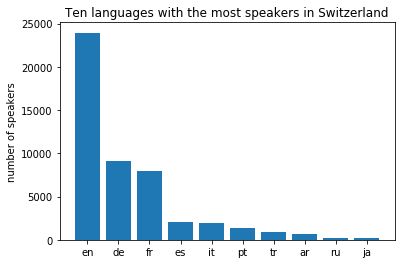

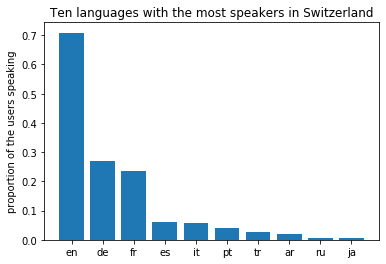

<Figure size 432x288 with 0 Axes>

In [52]:
user_langs_agg = uagg.get_lang_grp(user_langs_counts, area_dict,
                                   lang_relevant_prop=lang_relevant_prop,
                                   lang_relevant_count=lang_relevant_count,
                                   fig_dir=fig_dir, show_fig=True)

Attribute users to a group: mono, bi, tri, ... lingual

Problem: need more tweets to detect multilingualism, eg users with only three tweets in the dataset are very unlikely to be detected as multilinguals

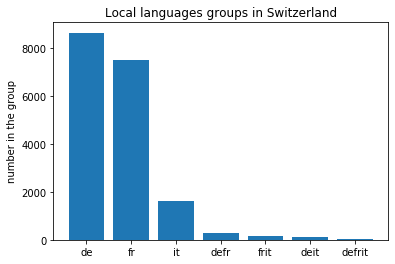

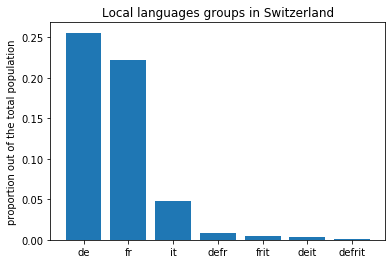

<Figure size 432x288 with 0 Axes>

In [53]:
users_ling_grp = uagg.get_ling_grp(
    user_langs_agg, area_dict, lang_relevant_prop=lang_relevant_prop,
    lang_relevant_count=lang_relevant_count, fig_dir=fig_dir, show_fig=True)

## Pre-residence attribution

In [ ]:
with mp.Pool(8) as pool:
    map_parameters = [(res, cells_in_area_df,
                       max_place_area, cc_timezone) 
                      for res in tweets_process_res]
    print('entering the loop')
    tweets_pre_resid_res = (
        pool.starmap_async(data_process.prep_resid_attr, map_parameters).get())
    
user_places_habits = None
user_cells_habits = None
for res in tweets_pre_resid_res:
    # We first count the number of times a user has tweeted in each place inside
    # and outside work hours.
    tweets_places_df = res[1]
    groupby_cols = ['uid', 'place_id', 'isin_workhour']
    user_places_habits = join_and_count.increment_counts(
        user_places_habits, tweets_places_df, groupby_cols)
    # Then we do the same thing except in each cell, using the tweets with
    # coordinates.
    tweets_cells_df = res[0]
    groupby_cols = ['uid', 'cell_id', 'isin_workhour']
    user_cells_habits = join_and_count.increment_counts(
        user_cells_habits, tweets_cells_df, groupby_cols)

Here we took number of speakers, whether they're multilingual or monolingual, if they speak a language, they count as one in that language's count

## Residence attribution

In [56]:
user_home_cell, user_only_place = uagg.get_residence(
    user_cells_habits, user_places_habits, place_relevant_th=cell_relevant_th,
    cell_relevant_th=cell_relevant_th)

## Generate cell data

In [29]:
cell_plot_df = data_process.from_users_area_and_lang(
    cells_in_area_df, places_geodf, user_only_place,
    user_home_cell, user_langs_agg, users_ling_grp,
    plot_langs_dict, multiling_grps, cell_data_path_format)

There are 9012 German-speaking users.
There are 7927 French-speaking users.
There are 1887 Italian-speaking users.


GeoJSON should always be in lat, lon, WGS84 to be read by external programs, so in plotly for instance we need to make sure we come back to latlon_proj

## Plots

In [72]:
cell_size = 10000
cell_data_path = cell_data_path_format.format(
    'users_cell_data', cc, cell_size, 'geojson')
cell_plot_df = geopd.read_file(cell_data_path)
cell_plot_df.index = cell_plot_df['cell_id']
cell_plot_df, plot_langs_dict = metrics.calc_by_cell(cell_plot_df, 
                                                     plot_langs_dict)

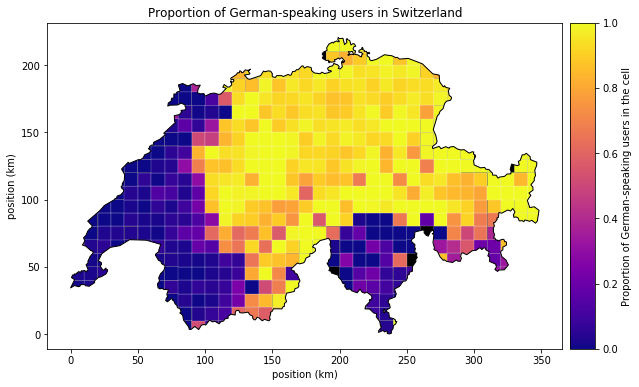

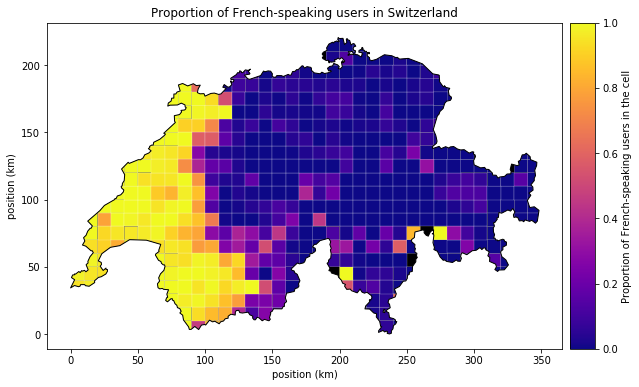

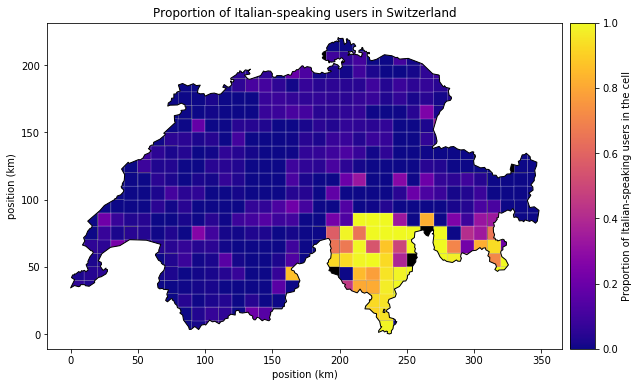

In [31]:
prop_dict = {'name': 'prop', 'readable': 'Proportion', 'log_scale': False, 
             'vmin': 0, 'vmax': 1, 'total_count_col': 'local_count'}
metric = prop_dict['name']
save_path_format = os.path.join(
    cc_fig_dir, metric, 
    f'users_{metric}_cc={cc}_grp={{grp}}_cell_size={cell_size}m.pdf')
ax = helpers_viz.metric_grid(
    cell_plot_df, prop_dict, shape_df, plot_langs_dict, country_name, 
    cmap='plasma', save_path_format=save_path_format, xy_proj=xy_proj, 
    min_count=0, null_color='k')

In [73]:
save_path = os.path.join(cc_fig_dir, 
            f'users_prop_cc={cc}_cell_size={cell_size}m.html')
prop_dict = {'name': 'prop', 'readable': 'Proportion', 'log_scale': False, 
             'vmin': 0, 'vmax': 1, 'total_count_col': 'local_count'}
fig = grid_viz.plot_interactive(
    cell_plot_df, shape_df, plot_langs_dict, prop_dict,
    save_path=save_path, plotly_renderer='iframe_connected', show=True)

# Generate cell data files in loops

In all the above, the cell size and cc are supposed constant, defined in config. Here we first assume the cell size is not constant, then the cc

In [4]:
import sys
import logging
import logging.config
import traceback
import IPython

# logger = logging.getLogger(__name__)
# load config from file
logging.config.fileConfig('logging.ini', disable_existing_loggers=False)

def showtraceback(self):
    traceback_lines = traceback.format_exception(*sys.exc_info())
    del traceback_lines[1]
    message = ''.join(traceback_lines)
    logging.error(message)
#     sys.stderr.write(message)
IPython.core.interactiveshell.InteractiveShell.showtraceback = showtraceback

In [30]:
tweets_files_format = 'tweets_{}_{}_{}.json.gz'
places_files_format = 'places_{}_{}_{}.json.gz'
source_data_dir = os.environ['DATA_DIR']
fig_dir = os.path.join('..', 'reports', 'figures')
project_data_dir = os.path.join('..', 'data')
external_data_dir = os.path.join(project_data_dir, 'external')
interim_data_dir = os.path.join(project_data_dir, 'interim')
processed_data_dir = os.path.join(project_data_dir, 'processed')
cell_data_path_format = os.path.join(
    processed_data_dir, '{0}', '{0}_cc={1}_r={2}_cell_size={3}m.{4}')
null_reply_id = 'e39d05b72f25767869d44391919434896bb055772d7969f74472032b03bc18418911f3b0e6dd47ff8f3b2323728225286c3cb36914d28dc7db40bdd786159c0a'
with open(os.path.join(external_data_dir, 'countries.json')) as f:
    countries_study_data = json.load(f)
with open(os.path.join(external_data_dir, 'langs_agg.json')) as f:
    langs_agg_dict = json.load(f)

## Countries loop 

In [31]:
cc = 'PY'
regions = ()
# regions = ('New York City', 'Puerto Rico')
# regions = ('Catalonia', 'Balearic islands', 'Galicia', 'Valencian Community', 
#            'Basque country')
# regions = ('Louisiana', 'Texas', 'New Mexico', 'Arizona', 'Nevada',
#           'California')
valid_uids_path_format = os.path.join(interim_data_dir, 'valid_uids_{}_{}.csv')

areas_dict = {'cc': cc, 'regions': {}}
if not regions:
    areas_dict['regions'] = {cc: countries_study_data[cc]}
for r in regions:
    areas_dict['regions'][r] = countries_study_data[cc]['regions'][r]

cell_sizes_list = [30000, 40000]
data_years = [(2015, 2019)]
tweets_files_paths = [
    os.path.join(source_data_dir,
                 tweets_files_format.format(year_from, year_to, cc))
    for year_from, year_to in data_years]
places_files_paths = [
    os.path.join(source_data_dir,
                 places_files_format.format(year_from, year_to, cc))
    for year_from, year_to in data_years]
lang_relevant_prop = 0.1
lang_relevant_count = 5
cell_relevant_th = 0.1

def get_df_fun(arg0):
    return data_access.read_json_wrapper(*arg0)

areas_dict = geo.init_cc(
    areas_dict, cell_sizes_list, places_files_paths, project_data_dir)

reading of places data files is done
places dataframe for PY generated
cells dataframes for PY generated


In [366]:
filters_pass_res = []
def collect_filters_pass_res(res):
    global filters_pass_res
    filters_pass_res.append(res)

areas_dict = ufilters.get_valid_uids(
    areas_dict, get_df_fun, collect_filters_pass_res,
    filters_pass_res, tweets_files_paths, cpus=8)
for region, region_dict in areas_dict['regions'].items():
    valid_uids = region_dict['valid_uids']
    valid_uids_path = valid_uids_path_format.format(areas_dict['cc'], 
                                                    region_dict['readable'])
    valid_uids.to_csv(valid_uids_path, header=True)

2020-04-30 14:28:47,520 - src.data.user_filters - INFO - - starting on chunk 0
2020-04-30 14:28:56,632 - src.data.user_filters - INFO - - starting on chunk 1
2020-04-30 14:29:05,689 - src.data.user_filters - INFO - - starting on chunk 2
2020-04-30 14:29:15,060 - src.data.user_filters - INFO - - starting on chunk 3
2020-04-30 14:29:24,542 - src.data.user_filters - INFO - - starting on chunk 4
2020-04-30 14:29:34,210 - src.data.user_filters - INFO - - starting on chunk 5
2020-04-30 14:29:39,310 - src.data.access - INFO - 1000MB read, 856450 tweets unpacked.
2020-04-30 14:29:44,016 - src.data.user_filters - INFO - - starting on chunk 6
2020-04-30 14:29:45,657 - src.data.access - INFO - 830503 tweets remaining after filters.
There are 43347 distinct users in this chunk.
2020-04-30 14:29:54,297 - src.data.access - INFO - 1000MB read, 860004 tweets unpacked.
2020-04-30 14:29:54,570 - src.data.user_filters - INFO - - starting on chunk 7
2020-04-30 14:30:00,481 - src.data.access - INFO - 83379

In [34]:
for region, region_dict in areas_dict['regions'].items():
    valid_uids_path = valid_uids_path_format.format(areas_dict['cc'], 
                                                    region_dict['readable'])
    valid_uids = pd.read_csv(valid_uids_path, index_col='uid', header=0)
    areas_dict['regions'][region]['valid_uids'] = valid_uids
    
user_agg_res = []
def collect_user_agg_res(res):
    global user_agg_res
    user_agg_res.append(res)

cells_results.from_scratch(
    areas_dict, 
    tweets_files_paths, get_df_fun, collect_user_agg_res, 
    user_agg_res, langs_agg_dict, cell_data_path_format, null_reply_id,
    lang_relevant_prop=0.1, lang_relevant_count=5, cell_relevant_th=0.1,
    place_relevant_th=0.1, fig_dir=fig_dir)

2020-06-04 11:38:43,882 - src.data.cells_results - INFO - starting on chunk 0
2020-06-04 11:38:53,009 - src.data.cells_results - INFO - starting on chunk 1
2020-06-04 11:39:02,469 - src.data.cells_results - INFO - starting on chunk 2
2020-06-04 11:39:11,418 - src.data.cells_results - INFO - starting on chunk 3
2020-06-04 11:39:20,707 - src.data.cells_results - INFO - starting on chunk 4
2020-06-04 11:39:27,000 - src.data.access - INFO - 1000MB read, 1045895 tweets unpacked.
2020-06-04 11:39:30,043 - src.data.cells_results - INFO - starting on chunk 5
2020-06-04 11:39:36,508 - src.data.access - INFO - 685997 tweets remaining after filters.
2020-06-04 11:39:39,542 - src.data.cells_results - INFO - starting on chunk 6
2020-06-04 11:39:48,955 - src.data.cells_results - INFO - starting on chunk 7
2020-06-04 11:39:55,285 - src.data.access - INFO - 1000MB read, 1028962 tweets unpacked.
2020-06-04 11:39:58,725 - src.data.cells_results - INFO - starting on chunk 8
2020-06-04 11:40:04,441 - src.

<Figure size 432x288 with 0 Axes>